# Benchmarking Fashion MNIST Dataset on LeNet-5

In [25]:
# Imports
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter


In [26]:
class LeNet5(nn.Module):
    def __init__(self, use_batch_norm=False, use_dropout=False, dropout_prob=0.5):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=[5, 5])
        self.avg_pool1 = nn.AvgPool2d(kernel_size=[2, 2], stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=[5, 5])
        self.avg_pool2 = nn.AvgPool2d(kernel_size=[2, 2], stride=2)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=[5, 5])
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)
        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout
        if use_batch_norm:
            self.batch_norm1 = nn.BatchNorm2d(6)
            self.batch_norm2 = nn.BatchNorm2d(16)
            self.batch_norm3 = nn.BatchNorm2d(120)
        if use_dropout:
            self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = self.conv1(x)
        if self.use_batch_norm:
            x = self.batch_norm1(x)
        x = torch.tanh(x)
        x = self.avg_pool1(x)

        x = self.conv2(x)
        if self.use_batch_norm:
            x = self.batch_norm2(x)
        x = torch.tanh(x)
        x = self.avg_pool2(x)

        x = self.conv3(x)
        if self.use_batch_norm:
            x = self.batch_norm3(x)
        x = torch.tanh(x)

        x = torch.flatten(x, 1)
        if self.use_dropout:
            x = self.dropout(x)
        x = torch.tanh(self.fc1(x))

        x = F.softmax(self.fc2(x), dim=1)
        return x

In [27]:
# Define hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 100
validation_split = 0.2
weight_decay = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
# Load the fashionMNIST dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize each image to 32x32 to fit to Lenet5 original dimensions
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
label_names = train_dataset.classes
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the validation split
train_size = int((1-validation_split) * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)




# Dataset Visualization

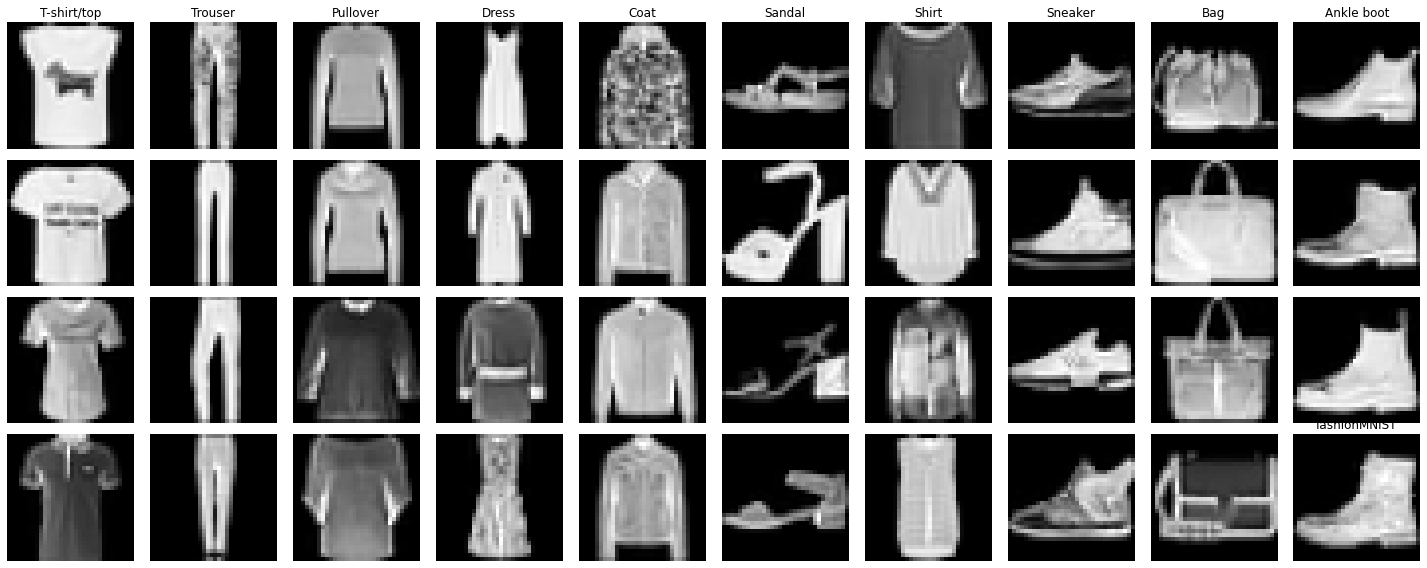

In [29]:
num_samples=4

label_to_images = {i: [] for i in range(10)}


for image, label in train_dataset:
    if len(label_to_images[label]) < num_samples:
        label_to_images[label].append(image)
    if all(len(images) == num_samples for images in label_to_images.values()):
        break

fig, axes = plt.subplots(num_samples, 10, figsize=(20, num_samples * 2))

for label in range(10):
    for i in range(num_samples):
        image = label_to_images[label][i].squeeze().numpy()
        axes[i, label].imshow(image, cmap='gray')
        axes[i, label].axis('off')
        if i == 0:
            axes[i, label].set_title(label_names[label], fontsize=12)

    
plt.tight_layout()
plt.title('fashionMNIST')
plt.show()

In [30]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    correct_test = 0
    total_test = 0
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    test_accuracy = 100. * correct_test / total_test
    average_loss = total_loss / len(test_loader)
    return test_accuracy, average_loss


# Define a function to visualize and log test samples with predictions
def log_test_samples(model, test_loader, writer, epoch, num_samples=5):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        img = images[i].cpu().numpy().squeeze()
        axs[i].imshow(img, cmap='gray')
        axs[i].set_title(f"Pred: {label_names[predicted[i].item()]}\nLabel: {label_names[labels[i].item()]}")
        axs[i].axis('off')
    
    writer.add_figure('Test Samples', fig, epoch)
    
    # Display the plot in the notebook
    plt.show()

In [31]:
def train_and_evaluate(run_name, model, optimizer, scheduler, train_loader, val_loader, test_loader, epochs, device, criterion = nn.CrossEntropyLoss()):
    # Add model graph to TensorBoard
    writer = SummaryWriter(fr'runs/{run_name}')
    dummy_input = torch.zeros(batch_size, 1, 32, 32).to(device)
    writer.add_graph(model, dummy_input)
    best_val_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        batch_loader = tqdm(train_loader, desc="Batches")
        for images, labels in batch_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            train_accuracy = 100. * correct_train / total_train
            batch_loader.set_description(f"{run_name} Epoch [{epoch+1}/{epochs}] Batch Loss: {loss.item():.4f} Train accuracy: {train_accuracy:.4f}")
        
        # Log the running loss to TensorBoard
        average_loss = running_loss / len(train_loader)
        train_accuracy = 100. * correct_train / total_train
        writer.add_scalar('Loss/Training', average_loss, epoch)
        
        # Log learning rate to TensorBoard
        current_lr = optimizer.param_groups[0]['lr']
        writer.add_scalar('Learning Rate', current_lr, epoch)
        
        validation_accuracy, validation_avg_loss = evaluate_model(model=model, test_loader=val_loader, criterion=criterion)
        
        test_accuracy, _ = evaluate_model(model=model, test_loader=test_loader, criterion=criterion)
        writer.add_scalars(fr'Accuracy/{run_name}', \
                           {'train': train_accuracy, \
                            'test': test_accuracy} \
                                       , epoch)
        
        # Log test samples with predictions to TensorBoard
        log_test_samples(model, test_loader, writer, epoch)
        
        # Step the scheduler and check if learning rate was reduced
        scheduler.step(validation_avg_loss)
        
        # Save the model if validation loss has decreased
        if validation_avg_loss < best_val_loss:
            best_val_loss = validation_avg_loss
            torch.save(model.state_dict(),  f'model_{run_name}.pth')


        batch_loader.set_description(f"{run_name} Epoch [{epoch+1}/{epochs}] Batch Loss: {loss.item():.4f} Train accuracy: {train_accuracy:.4f} Test accuracy: {test_accuracy:.4f}")

    # Evaluation on the test set
    print(f'Accuracy of model on test images: {test_accuracy:.2f}%')
    writer.close()

In [32]:
# # 1. LeNet5 Vanilla
# model_vanilla = LeNet5().to(device)
# optimizer = optim.Adam(model_vanilla.parameters(), lr=learning_rate)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
# train_and_evaluate('LeNet5_vanilla',model_vanilla, optimizer, scheduler, train_loader, val_loader, test_loader, epochs, device)

# # 2. LeNet5 with Batch Normalization
# model_bn = LeNet5(use_batch_norm=True).to(device)
# optimizer = optim.Adam(model_bn.parameters(), lr=learning_rate)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
# train_and_evaluate('LeNet5_bn', model_bn, optimizer, scheduler, train_loader, val_loader, test_loader, epochs, device)

# 3. LeNet5 with Dropout
model_dropout = LeNet5(use_batch_norm=False, use_dropout=True, dropout_prob=0.35).to(device)
optimizer = optim.Adam(model_dropout.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
train_and_evaluate('LeNet5_dropout', model_dropout, optimizer, scheduler, train_loader, val_loader, test_loader, epochs, device)

# # 4. LeNet5 with Weight Decay
model_weight_decay = LeNet5(use_batch_norm=False).to(device)
optimizer = optim.Adam(model_weight_decay.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
train_and_evaluate('LeNet5_weight_decay', model_weight_decay, optimizer, scheduler, train_loader, val_loader, test_loader, epochs, device)

LeNet5_dropout Epoch [1/100] Batch Loss: 1.6365 Train accuracy: 73.7875: 100%|██████████| 750/750 [00:21<00:00, 34.38it/s]
LeNet5_dropout Epoch [2/100] Batch Loss: 1.5867 Train accuracy: 81.3708: 100%|██████████| 750/750 [00:23<00:00, 31.87it/s]
LeNet5_dropout Epoch [3/100] Batch Loss: 1.5696 Train accuracy: 82.8229: 100%|██████████| 750/750 [00:22<00:00, 33.65it/s]
LeNet5_dropout Epoch [4/100] Batch Loss: 1.6703 Train accuracy: 83.7125: 100%|██████████| 750/750 [00:21<00:00, 35.07it/s]
LeNet5_dropout Epoch [5/100] Batch Loss: 1.5434 Train accuracy: 84.2354: 100%|██████████| 750/750 [00:21<00:00, 34.47it/s]
LeNet5_dropout Epoch [6/100] Batch Loss: 1.5981 Train accuracy: 85.0646: 100%|██████████| 750/750 [00:21<00:00, 34.65it/s]
LeNet5_dropout Epoch [7/100] Batch Loss: 1.5914 Train accuracy: 85.0854: 100%|██████████| 750/750 [00:21<00:00, 34.59it/s]
LeNet5_dropout Epoch [8/100] Batch Loss: 1.5954 Train accuracy: 85.4208: 100%|██████████| 750/750 [00:22<00:00, 32.94it/s]
LeNet5_dropout E

Epoch    53: reducing learning rate of group 0 to 1.0000e-04.


LeNet5_dropout Epoch [54/100] Batch Loss: 1.5205 Train accuracy: 90.8479: 100%|██████████| 750/750 [00:21<00:00, 34.35it/s]
LeNet5_dropout Epoch [55/100] Batch Loss: 1.5771 Train accuracy: 91.3583: 100%|██████████| 750/750 [00:20<00:00, 37.39it/s]
LeNet5_dropout Epoch [56/100] Batch Loss: 1.5360 Train accuracy: 91.3312: 100%|██████████| 750/750 [00:20<00:00, 36.69it/s]
LeNet5_dropout Epoch [57/100] Batch Loss: 1.4925 Train accuracy: 91.4833: 100%|██████████| 750/750 [00:21<00:00, 35.67it/s]
LeNet5_dropout Epoch [58/100] Batch Loss: 1.5671 Train accuracy: 91.5062: 100%|██████████| 750/750 [00:20<00:00, 36.93it/s]
LeNet5_dropout Epoch [59/100] Batch Loss: 1.5795 Train accuracy: 91.5229: 100%|██████████| 750/750 [00:20<00:00, 36.59it/s]
LeNet5_dropout Epoch [60/100] Batch Loss: 1.5512 Train accuracy: 91.7000: 100%|██████████| 750/750 [00:20<00:00, 36.27it/s]
LeNet5_dropout Epoch [61/100] Batch Loss: 1.4979 Train accuracy: 91.6917: 100%|██████████| 750/750 [00:19<00:00, 37.90it/s]
LeNet5_d

Epoch    87: reducing learning rate of group 0 to 1.0000e-05.


LeNet5_dropout Epoch [88/100] Batch Loss: 1.5704 Train accuracy: 92.3000: 100%|██████████| 750/750 [00:20<00:00, 36.99it/s]
LeNet5_dropout Epoch [89/100] Batch Loss: 1.5176 Train accuracy: 92.3438: 100%|██████████| 750/750 [00:21<00:00, 34.61it/s]
LeNet5_dropout Epoch [90/100] Batch Loss: 1.5437 Train accuracy: 92.2833: 100%|██████████| 750/750 [00:19<00:00, 38.11it/s]
LeNet5_dropout Epoch [91/100] Batch Loss: 1.5492 Train accuracy: 92.3312: 100%|██████████| 750/750 [00:19<00:00, 37.56it/s]
LeNet5_dropout Epoch [92/100] Batch Loss: 1.4934 Train accuracy: 92.4333: 100%|██████████| 750/750 [00:20<00:00, 37.00it/s]
LeNet5_dropout Epoch [93/100] Batch Loss: 1.5388 Train accuracy: 92.3187: 100%|██████████| 750/750 [00:20<00:00, 36.34it/s]


Epoch    93: reducing learning rate of group 0 to 1.0000e-06.


LeNet5_dropout Epoch [94/100] Batch Loss: 1.5317 Train accuracy: 92.4146: 100%|██████████| 750/750 [00:19<00:00, 37.79it/s]
LeNet5_dropout Epoch [95/100] Batch Loss: 1.4979 Train accuracy: 92.3312: 100%|██████████| 750/750 [00:20<00:00, 37.06it/s]
LeNet5_dropout Epoch [96/100] Batch Loss: 1.5527 Train accuracy: 92.4313: 100%|██████████| 750/750 [00:20<00:00, 36.85it/s]
LeNet5_dropout Epoch [97/100] Batch Loss: 1.5012 Train accuracy: 92.4062: 100%|██████████| 750/750 [00:20<00:00, 37.20it/s]
LeNet5_dropout Epoch [98/100] Batch Loss: 1.6021 Train accuracy: 92.3625: 100%|██████████| 750/750 [00:19<00:00, 37.50it/s]
LeNet5_dropout Epoch [99/100] Batch Loss: 1.5552 Train accuracy: 92.3604: 100%|██████████| 750/750 [00:20<00:00, 36.08it/s]


Epoch    99: reducing learning rate of group 0 to 1.0000e-07.


LeNet5_dropout Epoch [100/100] Batch Loss: 1.4854 Train accuracy: 92.3771: 100%|██████████| 750/750 [00:20<00:00, 36.29it/s]


Accuracy of model on test images: 89.07%


LeNet5_weight_decay Epoch [1/100] Batch Loss: 1.6582 Train accuracy: 74.9667: 100%|██████████| 750/750 [00:20<00:00, 37.05it/s]
LeNet5_weight_decay Epoch [2/100] Batch Loss: 1.6282 Train accuracy: 81.7521: 100%|██████████| 750/750 [00:20<00:00, 36.48it/s]
LeNet5_weight_decay Epoch [3/100] Batch Loss: 1.6102 Train accuracy: 83.2771: 100%|██████████| 750/750 [00:21<00:00, 35.21it/s]
LeNet5_weight_decay Epoch [4/100] Batch Loss: 1.6109 Train accuracy: 84.2062: 100%|██████████| 750/750 [00:20<00:00, 36.40it/s]
LeNet5_weight_decay Epoch [5/100] Batch Loss: 1.6775 Train accuracy: 84.5146: 100%|██████████| 750/750 [00:20<00:00, 37.43it/s]
LeNet5_weight_decay Epoch [6/100] Batch Loss: 1.6130 Train accuracy: 85.0625: 100%|██████████| 750/750 [00:20<00:00, 36.67it/s]
LeNet5_weight_decay Epoch [7/100] Batch Loss: 1.5366 Train accuracy: 85.3937: 100%|██████████| 750/750 [00:21<00:00, 35.69it/s]
LeNet5_weight_decay Epoch [8/100] Batch Loss: 1.6030 Train accuracy: 85.5062: 100%|██████████| 750/750 [

Epoch    44: reducing learning rate of group 0 to 1.0000e-04.


LeNet5_weight_decay Epoch [45/100] Batch Loss: 1.5972 Train accuracy: 90.0625: 100%|██████████| 750/750 [00:19<00:00, 38.19it/s]
LeNet5_weight_decay Epoch [46/100] Batch Loss: 1.5255 Train accuracy: 90.3958: 100%|██████████| 750/750 [00:19<00:00, 37.61it/s]
LeNet5_weight_decay Epoch [47/100] Batch Loss: 1.5760 Train accuracy: 90.4333: 100%|██████████| 750/750 [00:20<00:00, 36.45it/s]
LeNet5_weight_decay Epoch [48/100] Batch Loss: 1.5803 Train accuracy: 90.5187: 100%|██████████| 750/750 [00:20<00:00, 37.41it/s]
LeNet5_weight_decay Epoch [49/100] Batch Loss: 1.6017 Train accuracy: 90.6167: 100%|██████████| 750/750 [00:20<00:00, 36.59it/s]
LeNet5_weight_decay Epoch [50/100] Batch Loss: 1.6338 Train accuracy: 90.6479: 100%|██████████| 750/750 [00:20<00:00, 36.81it/s]
LeNet5_weight_decay Epoch [51/100] Batch Loss: 1.5588 Train accuracy: 90.7062: 100%|██████████| 750/750 [00:20<00:00, 36.46it/s]
LeNet5_weight_decay Epoch [52/100] Batch Loss: 1.5569 Train accuracy: 90.7333: 100%|██████████| 7

Epoch    69: reducing learning rate of group 0 to 1.0000e-05.


LeNet5_weight_decay Epoch [70/100] Batch Loss: 1.5931 Train accuracy: 91.3479: 100%|██████████| 750/750 [00:20<00:00, 36.59it/s]
LeNet5_weight_decay Epoch [71/100] Batch Loss: 1.5966 Train accuracy: 91.3729: 100%|██████████| 750/750 [00:20<00:00, 36.76it/s]
LeNet5_weight_decay Epoch [72/100] Batch Loss: 1.5343 Train accuracy: 91.4062: 100%|██████████| 750/750 [00:19<00:00, 38.03it/s]
LeNet5_weight_decay Epoch [73/100] Batch Loss: 1.5795 Train accuracy: 91.3854: 100%|██████████| 750/750 [00:20<00:00, 36.96it/s]
LeNet5_weight_decay Epoch [74/100] Batch Loss: 1.5058 Train accuracy: 91.4000: 100%|██████████| 750/750 [00:20<00:00, 36.47it/s]
LeNet5_weight_decay Epoch [75/100] Batch Loss: 1.6461 Train accuracy: 91.3958: 100%|██████████| 750/750 [00:25<00:00, 29.33it/s]
LeNet5_weight_decay Epoch [76/100] Batch Loss: 1.6027 Train accuracy: 91.4000: 100%|██████████| 750/750 [00:20<00:00, 37.45it/s]


Epoch    76: reducing learning rate of group 0 to 1.0000e-06.


LeNet5_weight_decay Epoch [77/100] Batch Loss: 1.5612 Train accuracy: 91.4396: 100%|██████████| 750/750 [00:20<00:00, 36.27it/s]
LeNet5_weight_decay Epoch [78/100] Batch Loss: 1.5921 Train accuracy: 91.4479: 100%|██████████| 750/750 [00:20<00:00, 36.41it/s]
LeNet5_weight_decay Epoch [79/100] Batch Loss: 1.5865 Train accuracy: 91.4500: 100%|██████████| 750/750 [00:21<00:00, 35.18it/s]
LeNet5_weight_decay Epoch [80/100] Batch Loss: 1.5916 Train accuracy: 91.4562: 100%|██████████| 750/750 [00:21<00:00, 35.43it/s]
LeNet5_weight_decay Epoch [81/100] Batch Loss: 1.5475 Train accuracy: 91.4417: 100%|██████████| 750/750 [00:23<00:00, 32.43it/s]
LeNet5_weight_decay Epoch [82/100] Batch Loss: 1.5964 Train accuracy: 91.4542: 100%|██████████| 750/750 [00:24<00:00, 30.99it/s]


Epoch    82: reducing learning rate of group 0 to 1.0000e-07.


LeNet5_weight_decay Epoch [83/100] Batch Loss: 1.5385 Train accuracy: 91.4521: 100%|██████████| 750/750 [00:22<00:00, 32.93it/s]
LeNet5_weight_decay Epoch [84/100] Batch Loss: 1.6007 Train accuracy: 91.4562: 100%|██████████| 750/750 [00:23<00:00, 31.93it/s]
LeNet5_weight_decay Epoch [85/100] Batch Loss: 1.5550 Train accuracy: 91.4521: 100%|██████████| 750/750 [00:22<00:00, 33.42it/s]
LeNet5_weight_decay Epoch [86/100] Batch Loss: 1.5947 Train accuracy: 91.4562: 100%|██████████| 750/750 [00:24<00:00, 30.81it/s]
LeNet5_weight_decay Epoch [87/100] Batch Loss: 1.5724 Train accuracy: 91.4542: 100%|██████████| 750/750 [00:21<00:00, 34.10it/s]
LeNet5_weight_decay Epoch [88/100] Batch Loss: 1.4957 Train accuracy: 91.4562: 100%|██████████| 750/750 [00:22<00:00, 33.03it/s]


Epoch    88: reducing learning rate of group 0 to 1.0000e-08.


LeNet5_weight_decay Epoch [89/100] Batch Loss: 1.5600 Train accuracy: 91.4562: 100%|██████████| 750/750 [00:22<00:00, 33.13it/s]
LeNet5_weight_decay Epoch [90/100] Batch Loss: 1.5034 Train accuracy: 91.4562: 100%|██████████| 750/750 [00:22<00:00, 33.63it/s]
LeNet5_weight_decay Epoch [91/100] Batch Loss: 1.5416 Train accuracy: 91.4562: 100%|██████████| 750/750 [00:22<00:00, 33.63it/s]
LeNet5_weight_decay Epoch [92/100] Batch Loss: 1.6018 Train accuracy: 91.4562: 100%|██████████| 750/750 [00:22<00:00, 33.36it/s]
LeNet5_weight_decay Epoch [93/100] Batch Loss: 1.5656 Train accuracy: 91.4562: 100%|██████████| 750/750 [00:22<00:00, 33.19it/s]
LeNet5_weight_decay Epoch [94/100] Batch Loss: 1.5055 Train accuracy: 91.4562: 100%|██████████| 750/750 [00:22<00:00, 32.99it/s]
LeNet5_weight_decay Epoch [95/100] Batch Loss: 1.5331 Train accuracy: 91.4562: 100%|██████████| 750/750 [00:22<00:00, 33.42it/s]
LeNet5_weight_decay Epoch [96/100] Batch Loss: 1.6071 Train accuracy: 91.4562: 100%|██████████| 7

Accuracy of model on test images: 88.98%
